In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "TALE"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn007791,MAEGFEPYHVPQQSRRDKLRVGGCVDNLQGCAGLLPAYDPSLIGPD...,507,1
1,Achn021251,MDDEAYGRLHTTADFSDNRPPPSEHLSLPVSHYPFASPPAFCDRSL...,307,1
2,Achn025901,MVSQDSPPNSASSILHQFIISDSISGQTQFENQHFEAYRNELRLIS...,430,1
3,Achn032201,MHISKEGCSSIGYGEAEELGPFFPQKGKPELKFNNHTWNKAANLLF...,294,1
4,Achn049161,MQIVVSSFDVVAGHGAAKPYTTLALKTISRHFRSLHDAISSQIRVT...,319,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
1490,0.000000,0.000000,0.000000,0.000000,0.000000,0.003086,0.009259,0.009259,0.000000,0.006173,...,0.000000,0.003086,0.000000,0.003086,0.003086,0.000000,0.003086,0.000000,0.0,0.000000
1363,0.018072,0.000000,0.001506,0.001506,0.001506,0.006024,0.001506,0.003012,0.004518,0.006024,...,0.000000,0.003012,0.000000,0.001506,0.003012,0.003012,0.003012,0.000000,0.0,0.000000
890,0.000000,0.003257,0.000000,0.003257,0.003257,0.006515,0.003257,0.000000,0.003257,0.000000,...,0.000000,0.003257,0.003257,0.000000,0.003257,0.000000,0.003257,0.000000,0.0,0.000000
8405,0.009259,0.000000,0.000000,0.006173,0.003086,0.006173,0.000000,0.003086,0.003086,0.003086,...,0.009259,0.003086,0.003086,0.000000,0.006173,0.000000,0.000000,0.000000,0.0,0.003086
7432,0.000000,0.000000,0.002625,0.000000,0.000000,0.002625,0.000000,0.000000,0.000000,0.007874,...,0.002625,0.005249,0.000000,0.007874,0.000000,0.000000,0.000000,0.002625,0.0,0.005249


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7069, 441)
X_test: (1768, 441)
y_train: (7069,)
y_test: (1768,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 56s 645ms/step - accuracy: 0.5781 - loss: 0.6930

30/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6086 - loss: 0.6851   

60/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7029 - loss: 0.6349

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7581 - loss: 0.5596 - val_accuracy: 0.9583 - val_loss: 0.1150


Epoch 2/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0676

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0393 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0350

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9909 - loss: 0.0333

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9911 - loss: 0.0326 - val_accuracy: 0.9859 - val_loss: 0.0441


Epoch 3/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0050

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0139 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0181

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0192

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0192 - val_accuracy: 0.9866 - val_loss: 0.0497


Epoch 4/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0013

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0103 

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0124

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0133

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0138 - val_accuracy: 0.9844 - val_loss: 0.0422


Epoch 5/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0054

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0220 

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9908 - loss: 0.0277

75/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.0285

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9909 - loss: 0.0283 - val_accuracy: 0.9859 - val_loss: 0.0446


Epoch 6/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0037

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0202 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0160

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0142

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0134 - val_accuracy: 0.9873 - val_loss: 0.0466


Epoch 7/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.1349

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0246 

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0193

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0170

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0161 - val_accuracy: 0.9873 - val_loss: 0.0412


Epoch 8/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0011

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0014 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0014

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0030

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0035 - val_accuracy: 0.9859 - val_loss: 0.0424


Epoch 9/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 8.3092e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9888 - loss: 0.0243     

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9915 - loss: 0.0207

75/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0190

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.0181 - val_accuracy: 0.9915 - val_loss: 0.0375


Epoch 10/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0011

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0014 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0015

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0019

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0024 - val_accuracy: 0.9880 - val_loss: 0.0436


Epoch 11/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0070

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0024 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0033

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0041

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0043 - val_accuracy: 0.9894 - val_loss: 0.0354


Epoch 12/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 6.6207e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0046     

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0042

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0037

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0038 - val_accuracy: 0.9887 - val_loss: 0.0402


Epoch 13/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 6.0635e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.7251e-04 

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0030    

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0042

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0045 - val_accuracy: 0.9915 - val_loss: 0.0390


Epoch 14/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0071

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0077 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0082

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0078

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0076 - val_accuracy: 0.9922 - val_loss: 0.0324


Epoch 15/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 6.5956e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 8.4959e-04 

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0050    

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0085

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0099 - val_accuracy: 0.9922 - val_loss: 0.0351


Epoch 16/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0029

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0131 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0117

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0104

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0098 - val_accuracy: 0.9922 - val_loss: 0.0354


Epoch 17/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 6.2492e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0032     

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0024

75/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0021

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0023 - val_accuracy: 0.9887 - val_loss: 0.0441


Epoch 18/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 5.1043e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0037     

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0038

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0036

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0035 - val_accuracy: 0.9901 - val_loss: 0.0425


Epoch 19/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 4.3867e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 8.9147e-04 

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0014    

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0017

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0018 - val_accuracy: 0.9738 - val_loss: 0.1143


Epoch 20/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0486

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0087 

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0079

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0076

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0074 - val_accuracy: 0.9901 - val_loss: 0.0425


Epoch 21/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0136

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0023 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0017

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0019

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0019 - val_accuracy: 0.9894 - val_loss: 0.0474


Epoch 22/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 7.1852e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0019     

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0014

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0021

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0031 - val_accuracy: 0.9887 - val_loss: 0.0477


Epoch 23/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0119

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.0159 

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0120

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0105

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0099 - val_accuracy: 0.9929 - val_loss: 0.0392


Epoch 24/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 7.8600e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 6.1322e-04 

54/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 7.2960e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 8.2890e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0014 - val_accuracy: 0.9894 - val_loss: 0.0479


Epoch 25/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 4.9442e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9900 - loss: 0.0191     

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0159

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0134

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0126 - val_accuracy: 0.9922 - val_loss: 0.0345


Epoch 26/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 4.8129e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 6.3065e-04 

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.8191e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 6.5816e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 7.0131e-04 - val_accuracy: 0.9929 - val_loss: 0.0400


Epoch 27/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 1.9331e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0021     

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0019

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0017

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0016 - val_accuracy: 0.9929 - val_loss: 0.0481


Epoch 28/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 4.4077e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0127     

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0123

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0111

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0106 - val_accuracy: 0.9922 - val_loss: 0.0372


Epoch 29/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 1.4964e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.1146e-04 

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.8107e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.7463e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.9659e-04 - val_accuracy: 0.9830 - val_loss: 0.0958


Epoch 30/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 5.6560e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9931 - loss: 0.0168     

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0143

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0122

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0113 - val_accuracy: 0.9929 - val_loss: 0.0379


Epoch 31/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 1.1484e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0038     

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0030

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0025

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0023 - val_accuracy: 0.9929 - val_loss: 0.0372


Epoch 32/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 1.1869e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.6282e-04 

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.0095e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.8585e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.7739e-04 - val_accuracy: 0.9936 - val_loss: 0.0411


Epoch 33/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 1.3347e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.2507e-05 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.3054e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.3823e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.3855e-04 - val_accuracy: 0.9929 - val_loss: 0.0432


Epoch 34/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 6.1724e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.5559e-05 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.2327e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.1362e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.2750e-04 - val_accuracy: 0.9936 - val_loss: 0.0409


Epoch 35/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 2.4585e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.7181e-04 

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.3896e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.5492e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.5612e-04 - val_accuracy: 0.9943 - val_loss: 0.0433


Epoch 36/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 7.3290e-06

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.1563e-05 

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.1222e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.8275e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.9846e-05 - val_accuracy: 0.9929 - val_loss: 0.0453


Epoch 37/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 3.3925e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.3305e-04 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.0824e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 9.4227e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 8.8896e-05 - val_accuracy: 0.9929 - val_loss: 0.0468


Epoch 38/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 1.6755e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.0876e-05 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.1759e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.1488e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.2907e-05 - val_accuracy: 0.9943 - val_loss: 0.0467


Epoch 39/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 1.0530e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.1744e-04 

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.3653e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.3313e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.2984e-04 - val_accuracy: 0.9936 - val_loss: 0.0490


Epoch 40/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 1.0510e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.9032e-05 

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.7772e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.0932e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.3702e-05 - val_accuracy: 0.9929 - val_loss: 0.0496


Epoch 41/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 2.6535e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.8156e-05 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.0492e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.7896e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 6.8053e-05 - val_accuracy: 0.9915 - val_loss: 0.0516


Epoch 42/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 1.3279e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.1009e-04 

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.4657e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.1599e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.0641e-04 - val_accuracy: 0.9936 - val_loss: 0.0497


Epoch 43/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 2.0975e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.2399e-04 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 9.4966e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.8123e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.1940e-05 - val_accuracy: 0.9915 - val_loss: 0.0532


Epoch 44/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 7.4316e-06

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.2913e-05 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.7018e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.3784e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.2376e-05 - val_accuracy: 0.9936 - val_loss: 0.0517


Epoch 45/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 2.7422e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.2551e-05 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.9925e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.3733e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.1558e-05 - val_accuracy: 0.9936 - val_loss: 0.0517



[Train Accuracy: 100.00% - Test Accuracy: 99.43%]


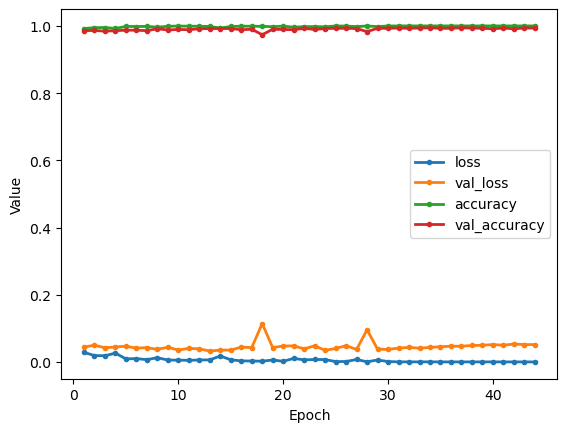

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step


 1/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
1490,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1363,0.004525,0.0,0.0,0.0,0.001508,0.003017,0.001508,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
890,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8405,0.003096,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.003096,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7432,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.002632,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7069, 8874)
X_test: (1768, 8874)
y_train: (7069,)
y_test: (1768,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,272,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,315,265 (8.83 MB)

 Trainable params: 2,315,265 (8.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 58s 661ms/step - accuracy: 0.4844 - loss: 0.6931

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4974 - loss: 0.6930   

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5232 - loss: 0.6921

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5693 - loss: 0.6900

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6119 - loss: 0.6862

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6481 - loss: 0.6800

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6781 - loss: 0.6704

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7031 - loss: 0.6567

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7241 - loss: 0.6394

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7421 - loss: 0.6201

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7576 - loss: 0.6002

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7711 - loss: 0.5804

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7831 - loss: 0.5613

89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7908 - loss: 0.5483 - val_accuracy: 0.9972 - val_loss: 0.0192


Epoch 2/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.0040

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0248 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9986 - loss: 0.0263

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9982 - loss: 0.0247

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9979 - loss: 0.0240

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9977 - loss: 0.0230

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9976 - loss: 0.0219

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9976 - loss: 0.0208

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9976 - loss: 0.0198

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9976 - loss: 0.0190

69/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9977 - loss: 0.0184

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9977 - loss: 0.0179

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9978 - loss: 0.0173

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9978 - loss: 0.0169 - val_accuracy: 0.9979 - val_loss: 0.0152


Epoch 3/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.0013

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0015 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0039

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0060

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0065

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - loss: 0.0066

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0070

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9994 - loss: 0.0071

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9994 - loss: 0.0070

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9994 - loss: 0.0070

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9994 - loss: 0.0069

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9994 - loss: 0.0069

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9993 - loss: 0.0068

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9993 - loss: 0.0068 - val_accuracy: 0.9979 - val_loss: 0.0136


Epoch 4/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 8.4781e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.5457e-04 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.2559e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.2150e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.1612e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.1067e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.8060e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 9.9424e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 0.0012    

65/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0013

72/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0014

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0015

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0016

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9997 - loss: 0.0017 - val_accuracy: 0.9979 - val_loss: 0.0161


Epoch 5/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.0012

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.8150e-04

16/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.7253e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.8728e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.2742e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.9942e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.8385e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.6444e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4570e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.3065e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.1574e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.0085e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.8636e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 6.8033e-04 - val_accuracy: 0.9979 - val_loss: 0.0152


Epoch 6/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 2.4539e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6338e-04 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9640e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9923e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9954e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9962e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9921e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9761e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0104e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0233e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0933e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1937e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2745e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.3148e-04 - val_accuracy: 0.9979 - val_loss: 0.0151


Epoch 7/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.6604e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6538e-04 

16/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4444e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3133e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2830e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2579e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3008e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3567e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8077e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 4.1038e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 5.2939e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 6.1891e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 6.9857e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9998 - loss: 7.2724e-04 - val_accuracy: 0.9979 - val_loss: 0.0205


Epoch 8/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 5.6383e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.0235e-04 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.0769e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.0725e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.9566e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.8253e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.9317e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.9647e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.9783e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.9803e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.9651e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.9357e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.8964e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.8650e-04 - val_accuracy: 0.9986 - val_loss: 0.0168


Epoch 9/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 2.2290e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2995e-05 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.5715e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.7490e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.7902e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.8611e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.8889e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.9560e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.9718e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.9672e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.9497e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.9235e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.8971e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 4.8775e-05 - val_accuracy: 0.9979 - val_loss: 0.0184


Epoch 10/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 2.1956e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.2002e-05 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.8214e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.7767e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.6596e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.5961e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.5542e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.5097e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.4707e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.4398e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.4339e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.4401e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.4346e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 3.4277e-05 - val_accuracy: 0.9979 - val_loss: 0.0190


Epoch 11/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.5650e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.0261e-05 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.2548e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.2940e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.2854e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2440e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1980e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.2074e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.2660e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.3249e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.3682e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.3998e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.4198e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.4283e-05 - val_accuracy: 0.9979 - val_loss: 0.0188


Epoch 12/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.7893e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.2280e-05 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.4737e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.6711e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7770e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7845e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7605e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7152e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.6600e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.6012e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5402e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.4821e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.4386e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.4159e-05 - val_accuracy: 0.9979 - val_loss: 0.0194


Epoch 13/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.2182e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7096e-05 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7285e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7927e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7984e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7764e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7432e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7102e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6795e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6492e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6236e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6072e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5982e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.5926e-05 - val_accuracy: 0.9979 - val_loss: 0.0204


Epoch 14/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 5.0474e-06

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3127e-05 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6910e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7918e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.8241e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9706e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1016e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1647e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.2068e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.2221e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.2198e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.2128e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.2134e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.2092e-05 - val_accuracy: 0.9979 - val_loss: 0.0203


Epoch 15/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.5548e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.3488e-06 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.8072e-06

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.6917e-06

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.6917e-06

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.7636e-06

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.7945e-06

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.8299e-06

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.8603e-06

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.9111e-06

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.0314e-06

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.1176e-06

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.2100e-06

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 9.2686e-06 - val_accuracy: 0.9979 - val_loss: 0.0202


Epoch 16/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 7.1916e-06

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.6962e-06 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4448e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6017e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6109e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5943e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5751e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5490e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5215e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4972e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4767e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4646e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4524e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 1.4458e-05 - val_accuracy: 0.9979 - val_loss: 0.0197


Epoch 17/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 5.3942e-06

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.4474e-06 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.9360e-06

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.9198e-06

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.8421e-06

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0324e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0602e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0917e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1219e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1450e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1620e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1707e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1797e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.1873e-05 - val_accuracy: 0.9979 - val_loss: 0.0202


Epoch 18/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 2.2638e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3007e-05 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0975e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.8804e-06

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.4023e-06

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.1986e-06

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.0344e-06

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.8896e-06

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.8205e-06

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.7464e-06

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.6608e-06

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.5800e-06

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.5221e-06

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 8.5227e-06 - val_accuracy: 0.9979 - val_loss: 0.0206



[Train Accuracy: 100.00% - Test Accuracy: 99.89%]


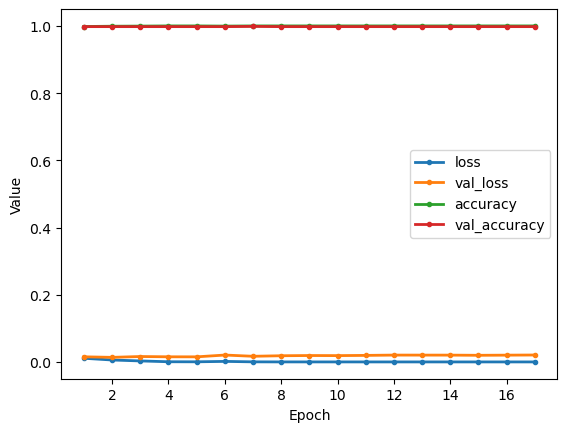

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

38/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 1/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

36/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
1490,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1363,0.001511,0.0,0.0,0.0,0.0,0.0,0.001511,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
890,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8405,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7432,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      38,470,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,511,361 (146.91 MB)

 Trainable params: 38,511,361 (146.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1:17 878ms/step - accuracy: 0.4844 - loss: 0.6932

 2/89 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 0.4766 - loss: 0.6932 

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.4896 - loss: 0.6932

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.4912 - loss: 0.6932

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.4961 - loss: 0.6931

 6/89 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.5011 - loss: 0.6930

 7/89 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.5041 - loss: 0.6929

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.5070 - loss: 0.6928

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.5074 - loss: 0.6928

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.5079 - loss: 0.6927

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.5077 - loss: 0.6926

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.5090 - loss: 0.6925

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.5110 - loss: 0.6924

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.5148 - loss: 0.6923

15/89 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.5198 - loss: 0.6921

16/89 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.5254 - loss: 0.6920

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.5313 - loss: 0.6918 

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.5370 - loss: 0.6916

19/89 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.5424 - loss: 0.6913

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.5480 - loss: 0.6911

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.5533 - loss: 0.6908

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.5584 - loss: 0.6905

23/89 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.5635 - loss: 0.6902

24/89 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.5687 - loss: 0.6898

25/89 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.5737 - loss: 0.6894

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.5787 - loss: 0.6890

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.5835 - loss: 0.6885

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.5883 - loss: 0.6880

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.5928 - loss: 0.6875

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.5974 - loss: 0.6869

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.6018 - loss: 0.6863

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.6061 - loss: 0.6857

33/89 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.6104 - loss: 0.6850

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.6147 - loss: 0.6843

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.6189 - loss: 0.6835

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.6230 - loss: 0.6827

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.6271 - loss: 0.6818

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.6311 - loss: 0.6808

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.6350 - loss: 0.6798

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.6389 - loss: 0.6788

41/89 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.6426 - loss: 0.6776

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.6463 - loss: 0.6764

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.6499 - loss: 0.6752

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.6534 - loss: 0.6739

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.6569 - loss: 0.6725

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.6603 - loss: 0.6711

47/89 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.6636 - loss: 0.6695

48/89 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.6669 - loss: 0.6679

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.6701 - loss: 0.6663

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.6732 - loss: 0.6646

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.6763 - loss: 0.6628

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.6793 - loss: 0.6610

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.6823 - loss: 0.6591

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.6852 - loss: 0.6571

55/89 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.6881 - loss: 0.6551

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.6909 - loss: 0.6530

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.6937 - loss: 0.6508

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.6964 - loss: 0.6487

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.6990 - loss: 0.6464

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.7016 - loss: 0.6442

61/89 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.7042 - loss: 0.6419

62/89 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.7067 - loss: 0.6395

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.7092 - loss: 0.6371

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.7116 - loss: 0.6347

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.7140 - loss: 0.6323

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.7163 - loss: 0.6298

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.7186 - loss: 0.6273

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.7209 - loss: 0.6248

69/89 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.7231 - loss: 0.6223

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7252 - loss: 0.6198

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7274 - loss: 0.6173

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7295 - loss: 0.6147

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7316 - loss: 0.6121

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7336 - loss: 0.6096

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7356 - loss: 0.6070

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.7376 - loss: 0.6044

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.7395 - loss: 0.6019

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.7414 - loss: 0.5993

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.7433 - loss: 0.5967

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.7451 - loss: 0.5942

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.7469 - loss: 0.5916

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.7487 - loss: 0.5891

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7505 - loss: 0.5865

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7522 - loss: 0.5840

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7539 - loss: 0.5815

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7556 - loss: 0.5790

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7572 - loss: 0.5765

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7589 - loss: 0.5740

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7605 - loss: 0.5715

89/89 ━━━━━━━━━━━━━━━━━━━━ 17s 183ms/step - accuracy: 0.7620 - loss: 0.5691 - val_accuracy: 0.9958 - val_loss: 0.0216


Epoch 2/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 27s 314ms/step - accuracy: 1.0000 - loss: 0.0086

 2/89 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - accuracy: 1.0000 - loss: 0.0073

 3/89 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 1.0000 - loss: 0.0064

 4/89 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 0.0059

 5/89 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 1.0000 - loss: 0.0056

 6/89 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 0.0053

 7/89 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 1.0000 - loss: 0.0051

 8/89 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - accuracy: 1.0000 - loss: 0.0050

 9/89 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 1.0000 - loss: 0.0049

10/89 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - accuracy: 0.9997 - loss: 0.0056

11/89 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.9995 - loss: 0.0060

12/89 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.9993 - loss: 0.0063

13/89 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - accuracy: 0.9992 - loss: 0.0065

14/89 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.9991 - loss: 0.0066

15/89 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.9990 - loss: 0.0068

16/89 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.9989 - loss: 0.0069

17/89 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - accuracy: 0.9989 - loss: 0.0070

18/89 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - accuracy: 0.9988 - loss: 0.0070

19/89 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.9988 - loss: 0.0071

20/89 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - accuracy: 0.9988 - loss: 0.0071

21/89 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.9988 - loss: 0.0071

22/89 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.9988 - loss: 0.0072

23/89 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.9988 - loss: 0.0072

24/89 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.9988 - loss: 0.0072

25/89 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.9988 - loss: 0.0072

26/89 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.9988 - loss: 0.0071

27/89 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.9988 - loss: 0.0071 

28/89 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.9988 - loss: 0.0071

29/89 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.9988 - loss: 0.0071

30/89 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.9988 - loss: 0.0071

31/89 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.9988 - loss: 0.0070

32/89 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.9988 - loss: 0.0070

33/89 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.9988 - loss: 0.0069

34/89 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.9988 - loss: 0.0069

35/89 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.9988 - loss: 0.0069

36/89 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.9988 - loss: 0.0069

37/89 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 0.9988 - loss: 0.0069

38/89 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 0.9988 - loss: 0.0069

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.9988 - loss: 0.0069

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.9988 - loss: 0.0069

41/89 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.9988 - loss: 0.0069

42/89 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.9988 - loss: 0.0069

43/89 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.9988 - loss: 0.0069

44/89 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.9988 - loss: 0.0069

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.9988 - loss: 0.0068

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.9988 - loss: 0.0068

47/89 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.9988 - loss: 0.0068

48/89 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.9988 - loss: 0.0068

49/89 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.9988 - loss: 0.0068

50/89 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.9988 - loss: 0.0067

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9988 - loss: 0.0067

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9988 - loss: 0.0067

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9989 - loss: 0.0067

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9989 - loss: 0.0067

55/89 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9989 - loss: 0.0066

56/89 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9989 - loss: 0.0066

57/89 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9989 - loss: 0.0066

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.9989 - loss: 0.0066

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.9989 - loss: 0.0065

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.9989 - loss: 0.0065

61/89 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.9989 - loss: 0.0065

62/89 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.9989 - loss: 0.0065

63/89 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.9989 - loss: 0.0064

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.9989 - loss: 0.0064

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.9989 - loss: 0.0064

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.9989 - loss: 0.0064

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.9989 - loss: 0.0063

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.9989 - loss: 0.0063

69/89 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.9989 - loss: 0.0063

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.9989 - loss: 0.0063

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.9989 - loss: 0.0063

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.9989 - loss: 0.0063

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.9989 - loss: 0.0062

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.9989 - loss: 0.0062

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.9989 - loss: 0.0062

76/89 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.9989 - loss: 0.0062

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.9989 - loss: 0.0062

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.9989 - loss: 0.0062

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.9989 - loss: 0.0062

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.9989 - loss: 0.0063

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.9989 - loss: 0.0063

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.9989 - loss: 0.0063

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9989 - loss: 0.0063

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9989 - loss: 0.0063

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9989 - loss: 0.0063

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9989 - loss: 0.0063

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9989 - loss: 0.0063

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9989 - loss: 0.0063

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9989 - loss: 0.0063

89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - accuracy: 0.9989 - loss: 0.0063 - val_accuracy: 0.9965 - val_loss: 0.0203


Epoch 3/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 18s 208ms/step - accuracy: 1.0000 - loss: 0.0014

 2/89 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 1.0000 - loss: 0.0014

 3/89 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - accuracy: 1.0000 - loss: 0.0014

 4/89 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - accuracy: 1.0000 - loss: 0.0013

 5/89 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 1.0000 - loss: 0.0013

 6/89 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 1.0000 - loss: 0.0012

 7/89 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 1.0000 - loss: 0.0012

 8/89 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 1.0000 - loss: 0.0012

 9/89 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 1.0000 - loss: 0.0012

10/89 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 1.0000 - loss: 0.0012

11/89 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 1.0000 - loss: 0.0011

12/89 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 1.0000 - loss: 0.0011

13/89 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 1.0000 - loss: 0.0011

14/89 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 1.0000 - loss: 0.0011

15/89 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 1.0000 - loss: 0.0011

16/89 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 1.0000 - loss: 0.0011

17/89 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 1.0000 - loss: 0.0011

18/89 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 1.0000 - loss: 0.0011

19/89 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 1.0000 - loss: 0.0011

20/89 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 1.0000 - loss: 0.0011

21/89 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 1.0000 - loss: 0.0010

22/89 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 1.0000 - loss: 0.0012

23/89 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.9999 - loss: 0.0014

24/89 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.9999 - loss: 0.0015 

25/89 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.9999 - loss: 0.0016

26/89 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.9999 - loss: 0.0017

27/89 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.9999 - loss: 0.0018

28/89 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.9998 - loss: 0.0019

29/89 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.9998 - loss: 0.0020

30/89 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.9998 - loss: 0.0020

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.9998 - loss: 0.0021

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.9998 - loss: 0.0022

33/89 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.9998 - loss: 0.0022

34/89 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.9998 - loss: 0.0022

35/89 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9998 - loss: 0.0023

36/89 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9998 - loss: 0.0023

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9998 - loss: 0.0023

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9998 - loss: 0.0024

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9998 - loss: 0.0024

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9998 - loss: 0.0024

41/89 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9997 - loss: 0.0024

42/89 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.9997 - loss: 0.0025

43/89 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.9997 - loss: 0.0025

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9997 - loss: 0.0025

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9997 - loss: 0.0025

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9997 - loss: 0.0025

47/89 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9997 - loss: 0.0025

48/89 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9997 - loss: 0.0025

49/89 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.9997 - loss: 0.0025

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.9997 - loss: 0.0025

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.9997 - loss: 0.0025

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.9997 - loss: 0.0025

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.9997 - loss: 0.0025

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.9997 - loss: 0.0025

55/89 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.9997 - loss: 0.0025

56/89 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.9997 - loss: 0.0025

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.9997 - loss: 0.0025

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.9997 - loss: 0.0025

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.9997 - loss: 0.0025

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.9997 - loss: 0.0025

61/89 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.9997 - loss: 0.0025

62/89 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.9997 - loss: 0.0025

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.9997 - loss: 0.0025

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.9997 - loss: 0.0025

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.9997 - loss: 0.0025

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.9997 - loss: 0.0025

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.9997 - loss: 0.0025

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.9997 - loss: 0.0025

69/89 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.9997 - loss: 0.0025

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.9997 - loss: 0.0025

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.9997 - loss: 0.0025

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.9997 - loss: 0.0025

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.9997 - loss: 0.0025

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.9997 - loss: 0.0025

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.9997 - loss: 0.0025

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.9997 - loss: 0.0025

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.9997 - loss: 0.0025

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9997 - loss: 0.0024

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9997 - loss: 0.0024

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.9997 - loss: 0.0024

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.9997 - loss: 0.0024

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.9997 - loss: 0.0024

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9997 - loss: 0.0024

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9997 - loss: 0.0024

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9997 - loss: 0.0024

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9997 - loss: 0.0024

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9997 - loss: 0.0024

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9997 - loss: 0.0024

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9997 - loss: 0.0024

89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 167ms/step - accuracy: 0.9998 - loss: 0.0024 - val_accuracy: 0.9965 - val_loss: 0.0221


Epoch 4/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 29s 331ms/step - accuracy: 1.0000 - loss: 3.9385e-04

 2/89 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step - accuracy: 1.0000 - loss: 5.0322e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - accuracy: 1.0000 - loss: 5.0127e-04

 4/89 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 1.0000 - loss: 5.0729e-04

 5/89 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 1.0000 - loss: 5.0198e-04

 6/89 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 1.0000 - loss: 4.9929e-04

 7/89 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 1.0000 - loss: 4.9430e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 1.0000 - loss: 4.8896e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - accuracy: 1.0000 - loss: 4.8407e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step - accuracy: 1.0000 - loss: 4.7899e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 1.0000 - loss: 4.7369e-04

12/89 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 1.0000 - loss: 4.6874e-04

13/89 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step - accuracy: 1.0000 - loss: 4.6360e-04

14/89 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 1.0000 - loss: 4.5905e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 1.0000 - loss: 4.5459e-04

16/89 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 1.0000 - loss: 4.5467e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 1.0000 - loss: 4.5558e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 1.0000 - loss: 4.5624e-04

19/89 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 1.0000 - loss: 4.5665e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 1.0000 - loss: 4.5659e-04

21/89 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 1.0000 - loss: 4.5607e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 1.0000 - loss: 4.5602e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 1.0000 - loss: 4.5575e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 1.0000 - loss: 4.5513e-04 

25/89 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 1.0000 - loss: 4.5429e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 1.0000 - loss: 4.5322e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 1.0000 - loss: 4.5238e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 1.0000 - loss: 4.5155e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 1.0000 - loss: 4.5072e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 1.0000 - loss: 4.4974e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 1.0000 - loss: 4.4870e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 1.0000 - loss: 4.4753e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 4.4624e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 4.4496e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 4.4368e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 4.4253e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 4.4138e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 4.4013e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 4.3932e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 4.3842e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 4.3746e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 4.3652e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 4.3555e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 4.3452e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 4.3346e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 4.3234e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 4.3118e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 4.3020e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 4.5632e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 4.8079e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 5.0373e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 5.2522e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 5.4553e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 5.6478e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 5.8287e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 6.0007e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 6.1660e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9999 - loss: 6.3222e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9999 - loss: 6.4707e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9999 - loss: 6.6306e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9999 - loss: 6.7827e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9999 - loss: 6.9267e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9999 - loss: 7.0636e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9999 - loss: 7.1940e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9999 - loss: 7.3174e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9999 - loss: 7.4340e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9999 - loss: 7.5445e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9999 - loss: 7.6492e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9999 - loss: 7.7490e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9999 - loss: 7.8436e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9999 - loss: 7.9387e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9999 - loss: 8.0292e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9999 - loss: 8.1152e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9999 - loss: 8.1968e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9999 - loss: 8.2741e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9999 - loss: 8.3476e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9999 - loss: 8.4174e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9999 - loss: 8.4836e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9999 - loss: 8.5464e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9999 - loss: 8.6065e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9999 - loss: 8.6637e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9999 - loss: 8.7177e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9999 - loss: 8.7689e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9999 - loss: 8.8174e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9999 - loss: 8.8633e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9999 - loss: 8.9072e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9999 - loss: 8.9487e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9999 - loss: 8.9880e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9999 - loss: 9.0259e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.9999 - loss: 9.0631e-04 - val_accuracy: 0.9972 - val_loss: 0.0228


Epoch 5/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 20s 233ms/step - accuracy: 1.0000 - loss: 4.6337e-04

 2/89 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 4.1500e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 4.1777e-04

 4/89 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 4.0443e-04

 5/89 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 3.9224e-04

 6/89 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 3.8488e-04

 7/89 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 3.7624e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 3.7391e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 3.7386e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 3.7154e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 3.6903e-04

12/89 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 3.6623e-04

13/89 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 3.6671e-04

14/89 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 3.6621e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 3.6522e-04

16/89 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 3.6356e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 3.6158e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 3.5964e-04

19/89 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 3.5757e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 3.5562e-04

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.5396e-04 

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.5207e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 3.5076e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.4924e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 3.4759e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.4589e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.4416e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 3.4258e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 3.4097e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 3.3957e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 3.3817e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 3.3674e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 3.3530e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 3.3379e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 3.3232e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 3.3093e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 3.2955e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 3.2822e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 3.2692e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 3.2559e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 3.2423e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 3.2288e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 3.2230e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 3.2172e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 3.2112e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 3.2046e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 3.1978e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 3.1904e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 3.1828e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 3.1749e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 3.1669e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 3.1588e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 3.1507e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 3.1428e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 3.1408e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 3.1383e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 3.1355e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 3.1327e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 3.1295e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 3.1260e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 3.1223e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 3.1182e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 3.1156e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 3.1128e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 3.1096e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 3.1063e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 3.1028e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 3.0991e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 3.0951e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 3.0912e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 3.0871e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 3.0829e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 3.0789e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 3.0747e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 3.0703e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 3.0659e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 3.0612e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 3.0572e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 3.0531e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 3.0488e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 3.0443e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 3.0398e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 3.0351e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 3.0304e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 3.0256e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 3.0208e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 3.0160e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 3.0112e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 3.0064e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 1.0000 - loss: 3.0017e-04 - val_accuracy: 0.9972 - val_loss: 0.0254


Epoch 6/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 24s 277ms/step - accuracy: 1.0000 - loss: 1.2615e-04

 2/89 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 1.2068e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 1.0000 - loss: 1.4234e-04

 4/89 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.4781e-04

 5/89 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 1.5380e-04

 6/89 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 1.5509e-04

 7/89 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 1.5486e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 1.5415e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 1.5306e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 1.5180e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 1.5039e-04

12/89 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 1.4887e-04

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 1.4751e-04

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.4613e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 1.4467e-04

16/89 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 1.4324e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 1.4229e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 1.4137e-04

19/89 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 1.4055e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 1.3971e-04

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 1.3888e-04 

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 1.3885e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.3872e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.3846e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 1.3816e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 1.3783e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 1.3741e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 1.3719e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 1.3696e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 1.3683e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 1.3678e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 1.3692e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 1.3699e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 1.3698e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.3760e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 1.3811e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 1.3857e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 1.3902e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 1.3945e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 1.3984e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 1.4014e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.4039e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.4059e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.4079e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.4107e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.4132e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.4152e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 1.4167e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 1.4180e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 1.4195e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 1.4207e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 1.4219e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 1.4252e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 1.4281e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 1.4305e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 1.4326e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 1.4343e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 1.4363e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 1.4380e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 1.4395e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 1.4406e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 1.4415e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 1.4423e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 1.4432e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 1.4442e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 1.4449e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 1.4456e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 1.4463e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 1.4469e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 1.4473e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 1.4475e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 1.4476e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 1.4475e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 1.4474e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 1.4474e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 1.4472e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 1.4470e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 1.0000 - loss: 1.4467e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 1.0000 - loss: 1.4463e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 1.0000 - loss: 1.4458e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 1.0000 - loss: 1.4452e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 1.4446e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 1.0000 - loss: 1.4439e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 1.0000 - loss: 1.4432e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 1.0000 - loss: 1.4424e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 1.0000 - loss: 1.4415e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 1.0000 - loss: 1.4406e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 1.0000 - loss: 1.4397e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 1.4387e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 1.0000 - loss: 1.4377e-04 - val_accuracy: 0.9972 - val_loss: 0.0263


Epoch 7/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 18s 215ms/step - accuracy: 1.0000 - loss: 1.0126e-04

 2/89 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 1.0000 - loss: 1.0518e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 1.0006e-04

 4/89 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 1.0000 - loss: 9.5747e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 9.4256e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 1.0000 - loss: 9.2109e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 1.0000 - loss: 9.0399e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 1.0000 - loss: 8.9634e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 1.0000 - loss: 8.8362e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 1.0000 - loss: 8.6852e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 1.0000 - loss: 8.5826e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 8.4943e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 8.4322e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 8.3771e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 8.3467e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 8.3118e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 8.2845e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 8.2613e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 8.2418e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 8.2191e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 8.1966e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 8.1740e-05 

23/89 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 8.1552e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 8.1359e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 8.1161e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 8.0971e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 8.0858e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 8.0721e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 8.0578e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 8.0448e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 8.0279e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 8.0089e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 7.9896e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 7.9704e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 7.9505e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 7.9310e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 7.9129e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 7.9011e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 7.8934e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 7.8983e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 7.8995e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 7.8997e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 7.8993e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 7.8979e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 7.8959e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 7.8979e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 7.8992e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 7.9003e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 7.8999e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 7.8995e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 7.8977e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 7.8939e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 7.8911e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 7.8883e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 7.8853e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 7.8812e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 1.0000 - loss: 7.8757e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 1.0000 - loss: 7.8698e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 1.0000 - loss: 7.8634e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 7.8581e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 1.0000 - loss: 7.8526e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 1.0000 - loss: 7.8481e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 1.0000 - loss: 7.8436e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 1.0000 - loss: 7.8388e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 7.8342e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 7.8292e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 7.8247e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 7.8219e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 7.8189e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 7.8185e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 7.8169e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 7.8157e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 7.8144e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 7.8130e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 7.8112e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 7.8091e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 7.8065e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 7.8034e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 7.7995e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 7.7961e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 7.7936e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 7.7905e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 1.0000 - loss: 7.7872e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 1.0000 - loss: 7.7845e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 1.0000 - loss: 7.7817e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 7.7783e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 7.7744e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 7.7715e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 7.7686e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 1.0000 - loss: 7.7658e-05 - val_accuracy: 0.9972 - val_loss: 0.0282


Epoch 8/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 19s 223ms/step - accuracy: 1.0000 - loss: 6.4966e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 5.4019e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 4.9028e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 4.7898e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 4.9033e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 4.9279e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 4.8898e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 4.8848e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 4.8968e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 4.9116e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 4.9035e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 4.9620e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 5.0395e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 5.1217e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 5.1736e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 5.2093e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 5.2404e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 5.2614e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 5.2764e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 5.2811e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 5.2786e-05 

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 5.2797e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 5.2825e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 5.2855e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 5.2860e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 5.2881e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 5.3393e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 5.3831e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 5.4202e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 5.4532e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 5.4832e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 5.5077e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 5.5282e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 5.5472e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 5.5624e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 5.5741e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 5.5857e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 5.5958e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 5.6035e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 5.6081e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 5.6129e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 5.6162e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 5.6239e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 5.6307e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 5.6370e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 5.6421e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 5.6468e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 5.6497e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 5.6509e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 5.6507e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 5.6521e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 5.6524e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 5.6526e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 5.6524e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 5.6510e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 5.6504e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 5.6489e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 5.6468e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 5.6439e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 5.6408e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 5.6407e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 5.6421e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 5.6431e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 5.6435e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 5.6438e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 5.6436e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 5.6427e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 5.6420e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 5.6409e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 5.6404e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 5.6395e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 5.6387e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 5.6380e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 5.6371e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 5.6359e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 5.6342e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 5.6318e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 5.6291e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 5.6266e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 5.6250e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 5.6230e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 5.6204e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 5.6187e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 5.6165e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 5.6139e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 5.6121e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 5.6107e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 5.6094e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 5.6080e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 1.0000 - loss: 5.6066e-05 - val_accuracy: 0.9972 - val_loss: 0.0295


Epoch 9/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 22s 252ms/step - accuracy: 1.0000 - loss: 3.1081e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 1.0000 - loss: 3.4825e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 3.9063e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 4.2030e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 4.3675e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 4.4132e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 4.5488e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 4.8156e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 4.9860e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 5.1044e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 5.1809e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 5.2167e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 5.2652e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 5.2901e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 5.2951e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 5.2892e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 5.2877e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 5.2798e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 5.2724e-05 

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 5.2700e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 5.2636e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 5.2732e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 5.2801e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 5.2839e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 5.2834e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 5.2772e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 5.2852e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 5.2951e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 5.3025e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 5.3056e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 5.3054e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 5.3061e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 5.3030e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 5.2994e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 5.2932e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 5.2848e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 5.2740e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 5.2620e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 5.2484e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 5.2334e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 5.2190e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 5.2040e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 5.1888e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 5.1739e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 5.1582e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 5.1419e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 5.1250e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 5.1077e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 5.0897e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 5.0723e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 5.0550e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 5.0381e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 5.0207e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 5.0033e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 4.9856e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 4.9681e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 4.9504e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 4.9325e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 4.9143e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 4.8962e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 4.8781e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 4.8608e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 4.8444e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 4.8283e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 4.8131e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 4.7984e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 4.7839e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 4.7693e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 4.7546e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 4.7399e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 4.7252e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 4.7105e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 4.6961e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 4.6820e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 4.6680e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 4.6551e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 4.6435e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 4.6319e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 4.6204e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 4.6102e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 4.6000e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 4.5901e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 4.5799e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 4.5698e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 4.5597e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 4.5495e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 4.5392e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 4.5289e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 4.5186e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 1.0000 - loss: 4.5086e-05 - val_accuracy: 0.9972 - val_loss: 0.0306


Epoch 10/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 17s 201ms/step - accuracy: 1.0000 - loss: 1.5061e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 1.0000 - loss: 1.6407e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 1.7268e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 1.8035e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.9449e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 2.0773e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 2.1740e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 2.2162e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 2.2313e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.2574e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 2.2672e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 2.2739e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 2.2795e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 2.2853e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 2.2933e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 2.2993e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 2.3026e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 2.3061e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 2.3045e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 2.3005e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.2988e-05 

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 2.2965e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.3116e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.3231e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.3313e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.3421e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.3502e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.3682e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.3828e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.3958e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.4061e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.4143e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.4259e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.4369e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.4469e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 2.4551e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.4630e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.4708e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.4782e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.4848e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.4901e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.4951e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.5019e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.5078e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.5130e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.5181e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.5233e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 2.5276e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.5318e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 2.5352e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 2.5380e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 2.5414e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 2.5445e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 2.5471e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 2.5500e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 2.5537e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 2.5569e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 2.5596e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 2.5625e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 2.5651e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 2.5689e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 2.5722e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 2.5753e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 2.5780e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 2.5805e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 2.5836e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 2.5865e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 2.5894e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 2.5920e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 2.5945e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 2.5966e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 2.5987e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 2.6008e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 2.6026e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 2.6045e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 2.6063e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 2.6079e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 2.6092e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 2.6103e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 2.6114e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 2.6124e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 2.6139e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 2.6152e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 2.6164e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 2.6180e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.6194e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.6206e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.6217e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.6227e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 1.0000 - loss: 2.6236e-05 - val_accuracy: 0.9972 - val_loss: 0.0313


Epoch 11/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 18s 215ms/step - accuracy: 1.0000 - loss: 1.8631e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 1.6004e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 1.0000 - loss: 1.5018e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.7644e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 1.8704e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 1.9073e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.9038e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 1.9094e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 1.9021e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 1.9031e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 1.8926e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 1.8748e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 1.8575e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 1.8432e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 1.8303e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 1.8200e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 1.8092e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 1.8049e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 1.7983e-05 

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 1.7923e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 1.7888e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 1.7842e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 1.8010e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 1.8151e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 1.8257e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.8348e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 1.8458e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 1.8554e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 1.8642e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 1.8733e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 1.8812e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 1.8878e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 1.8954e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 1.9056e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 1.9149e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 1.9259e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 1.9359e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 1.9451e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 1.9541e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 1.9622e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 1.9695e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 1.9760e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 1.9831e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 1.9904e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 1.9971e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 2.0029e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 2.0081e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 2.0123e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 2.0172e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 2.0221e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 2.0265e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 2.0305e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 2.0343e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 2.0375e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 2.0401e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 2.0432e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 2.0459e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 2.0482e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 2.0502e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 2.0524e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 2.0543e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 2.0559e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 2.0581e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 2.0599e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 2.0615e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 2.0630e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 2.0642e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 2.0653e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.0661e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.0670e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.0676e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.0682e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.0684e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.0683e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.0682e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 2.0679e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 2.0676e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.0672e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.0672e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.0673e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.0673e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 2.0674e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.0674e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.0679e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.0682e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.0684e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.0684e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.0683e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 2.0681e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 1.0000 - loss: 2.0680e-05 - val_accuracy: 0.9972 - val_loss: 0.0320


Epoch 12/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - accuracy: 1.0000 - loss: 6.2578e-06

 2/89 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 1.0000 - loss: 1.2483e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 1.9169e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 2.1114e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 2.1443e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.2016e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.2024e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 2.1978e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.2161e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.2191e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.2060e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.1939e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.1769e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.1584e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.1428e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.1266e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.1108e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 2.0982e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 2.0838e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 2.0722e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 2.0626e-05 

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 2.0555e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 2.0497e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 2.0525e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 2.0540e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 2.0538e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 2.0526e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 2.0547e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 2.0571e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 2.0577e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 2.0589e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 2.1102e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 2.1565e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 2.1976e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 2.2345e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 2.2671e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 2.2959e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 2.3220e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 2.3451e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 2.3661e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 2.3848e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.4026e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.4206e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.4372e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.4526e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.4661e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.4783e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 2.4981e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 2.5161e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 2.5331e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 2.5486e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 2.5640e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 2.5780e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 2.5908e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 2.6024e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 2.6127e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 2.6220e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 2.6310e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 2.6392e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 2.6474e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 2.6550e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 2.6620e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 2.6680e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 2.6733e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 2.6780e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 2.6822e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 2.6859e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 2.6894e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.6924e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.6949e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.6969e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.6985e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 2.7000e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.7010e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 2.7017e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 2.7021e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 2.7024e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 2.7024e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 2.7025e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 2.7023e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 2.7021e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 2.7018e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 2.7013e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 2.7005e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 2.6994e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 2.6982e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 2.6968e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 2.6952e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 2.6936e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 1.0000 - loss: 2.6920e-05 - val_accuracy: 0.9972 - val_loss: 0.0321


Epoch 13/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 24s 277ms/step - accuracy: 1.0000 - loss: 9.9983e-06

 2/89 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - accuracy: 1.0000 - loss: 1.7620e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 1.0000 - loss: 1.8578e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - accuracy: 1.0000 - loss: 1.8214e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 1.7799e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 1.7906e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 1.7875e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 1.7698e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 1.8218e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 1.8538e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 1.8735e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 1.8844e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 1.8916e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 1.8934e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 1.8908e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 1.8855e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 1.8803e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 1.8749e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 1.8668e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.8625e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.8586e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 1.8532e-05 

23/89 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 1.8466e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 1.8390e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.8311e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 1.8232e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 1.8158e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 1.8120e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 1.8069e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 1.8013e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 1.7962e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 1.7911e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 1.7855e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 1.7808e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.7753e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.7693e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.7636e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.7582e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.7536e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.7493e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.7453e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.7411e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.7366e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.7331e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.7293e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.7253e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.7210e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 1.7166e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.7123e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.7079e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.7034e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.6994e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.6953e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.6910e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.6868e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.6823e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.6779e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.6738e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.6698e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.6657e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.6619e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.6581e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 1.6542e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 1.6503e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 1.6472e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 1.6442e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 1.6417e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 1.6391e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 1.6365e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 1.6340e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 1.6316e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 1.6292e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 1.6266e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 1.6241e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 1.6215e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.6188e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.6161e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.6133e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.6106e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.6079e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.6056e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.6034e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 1.6011e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 1.5989e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.5967e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.5947e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.5926e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.5907e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.5887e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 1.0000 - loss: 1.5869e-05 - val_accuracy: 0.9972 - val_loss: 0.0335


Epoch 14/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 24s 276ms/step - accuracy: 1.0000 - loss: 5.9638e-06

 2/89 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 8.6550e-06

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 9.5461e-06

 4/89 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 9.7204e-06

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 9.6325e-06

 6/89 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 1.0176e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 1.0667e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.0947e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.1141e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 1.1284e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.1338e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.1327e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.1300e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 1.1303e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 1.1278e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.1279e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.1265e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.1253e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 1.1295e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.1359e-05 

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.1445e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.1525e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.1595e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 1.1645e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 1.1681e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 1.1707e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 1.1741e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 1.1776e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 1.1798e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 1.1810e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 1.1813e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.1817e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 1.1828e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.1837e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.1869e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 1.1902e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 1.1932e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 1.1957e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 1.1980e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 1.2000e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.2015e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.2033e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 1.2058e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 1.2082e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.2102e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.2118e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 1.2139e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 1.2155e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 1.2167e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.2176e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.2181e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.2186e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 1.2190e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 1.2194e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 1.2196e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 1.2206e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 1.2224e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 1.2239e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 1.2254e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 1.2266e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 1.2281e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.2294e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.2304e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.2318e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.2329e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.2338e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.2345e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.2352e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 1.2357e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 1.2362e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 1.2364e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 1.2365e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 1.2365e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 1.2363e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 1.2364e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.2362e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.2360e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.2357e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.2354e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.2372e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.2388e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.2403e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 1.2417e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 1.2429e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 1.2440e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.2449e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.2458e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.2469e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.2479e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 1.0000 - loss: 1.2489e-05 - val_accuracy: 0.9972 - val_loss: 0.0344



[Train Accuracy: 100.00% - Test Accuracy: 99.77%]


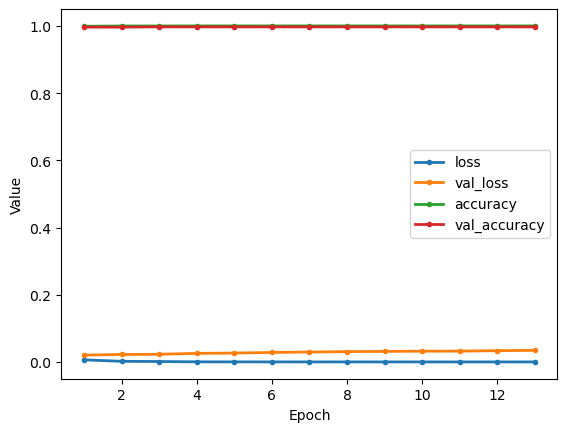

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/56 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step

 5/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

 9/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

13/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

18/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

22/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

26/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

30/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

34/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

38/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 1/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step

 6/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

10/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

14/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

18/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

22/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

26/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

30/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

34/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

38/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [26]:
report.save()

Report saved as Output/Reports/TALE/report_5EUB07UJ.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################